# Проект: классификация

### Данные о клиентах банка:

- **age** (возраст);
- **job** (сфера занятости);
- **marital** (семейное положение);
- **education** (уровень образования);
- **default** (имеется ли просроченный кредит);
- **housing** (имеется ли кредит на жильё);
- **loan** (имеется ли кредит на личные нужды);
- **balance** (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- **contact** (тип контакта с клиентом);
- **month** (месяц, в котором был последний контакт);
- **day** (день, в который был последний контакт);
- **duration** (продолжительность контакта в секундах).

### Прочие признаки:

- **campaign** (количество контактов с этим клиентом в течение текущей кампании);
- **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- **previous** (количество контактов до текущей кампании)
- **poutcome** (результат прошлой маркетинговой кампании).

И, разумеется, наша *целевая переменная* **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

> Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
list(df.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

> Вы успешно справились с предыдущим заданием и выяснили количество пропущенных значений. Однако в настоящих данных обычно всё не так просто, и пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости). Узнайте, каким именно словом закодированы пропущенные (неизвестные) значения.

### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

> Мы нашли пропущенные значения, и хотелось бы теперь их обработать. Однако мы не можем этого сделать, так как не все данные представлены в корректном виде.

> Обратите внимание на признак balance: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработайте данные этого признака так, чтобы он был преобразован в тип float.

### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def clean_balance(x):
    if pd.isna(x):  # Проверка на NaN
        return None
    elif ',' in x:
        x = x.strip().split(',')[0].replace(' ','')
        return int(x)
    else:
        x = x.strip().split(' $')[0].replace(' ','')
        return int(x)

df['balance'] = df['balance'].apply(clean_balance)

df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

> Итак, значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Конечно, пропуски можно было бы просто удалить, но мы поступим по-другому: заменим пропуски на медианное значение по этому признаку.

### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

df['balance'] = df['balance'].apply(lambda x: round(df['balance'].median()) if pd.isna(x) else x)

> Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. Однако нам всё равно важно их обработать. Мы знаем, что для категориальных признаков пропущенные значения заменяются модой по данному признаку.

> Замените все пропущенные значения в признаке job на модальные. То же самое сделайте с признаком, отвечающим за уровень образования.

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [11]:
round(df[(df['education'] == df['balance'].value_counts().index[0]) & (df['job'] == df['job'].value_counts().index[0])]['balance'].mean(),3)

nan

> Изучите признак, отображающий баланс клиентов, на предмет выбросов.

> В математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха () , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (). Найдите эти границы, и отфильтруйте значения так, чтобы выбросов в данных не осталось.

> **Примечание. Несмотря на то что существуют более продвинутые методы поиска аномальных значений, для обработки одного числового признака достаточно хорошо подходит метод Тьюки. После решения задачи вы сможете попробовать применить и другие методы, оценив их влияние на качество поиска.**

### Задание 6

In [12]:
df['balance'].mean()

np.float64(1526.9360329690019)

In [13]:
# удалите все выбросы для признака balance
# ваш код

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(f'Нижняя граница: {lower_bound}')
    print(f'Верхняя граница: {upper_bound}')
    return outliers, cleaned

In [14]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [15]:
df = df.drop(list(outliers.index), axis= 0)

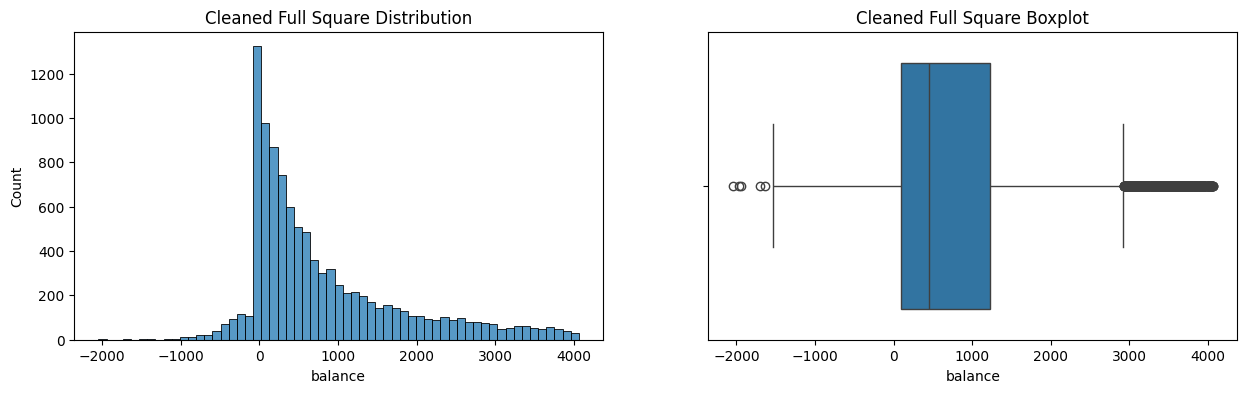

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

## Часть 2:  Разведывательный анализ

### Задание 1

> Давайте изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислите частоты для открывших депозит и для тех, кто его не открыл. Сопроводите числа диаграммой, отражающей полученные результаты.

In [17]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


> Начнём с описательных статистик для количественных переменных.

- Рассчитайте их и продумайте подробную интерпретацию.
- Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.
- Рассмотрите минимальные и максимальные значения.
- Посмотрите на меры разброса и оцените, насколько данные вариативны.
- Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.
- Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

### Задания 2 и 3

In [19]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Каков максимальный возраст клиента банка?
df['age'].max()

np.int64(95)

In [20]:
# Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.
df['duration'].min()

np.int64(2)

> Теперь давайте рассмотрим описательные статистики для категориальных переменных.

> Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

> **Совет. Вопросы, приведённые выше, — это лишь пример того, что можно рассмотреть. Постарайтесь самостоятельно составить различные выводы и описать их. Сделайте информативные и красивые визуализации, дополняющие ваши выводы.**

### Задания 4 и 5

In [21]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

# Сколько было месяцев, в которых проводилась маркетинговая кампания?
df['month'].value_counts().shape[0]

12

In [22]:
# Сколько сфер занятости представлено среди клиентов банка?
df['job'].value_counts().shape[0]

11

> Теперь давайте узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 6

In [23]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

df['poutcome'].value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

> Теперь давайте узнаем, какова зависимость результата маркетинговых кампаний от месяца. Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

### Задание 7

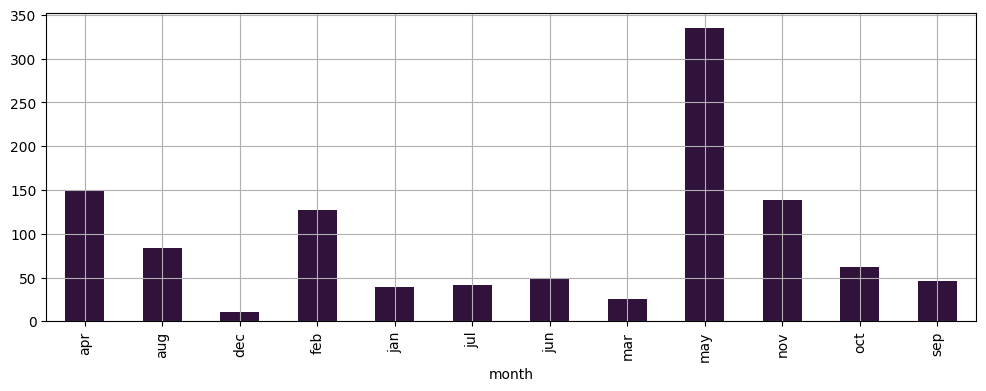

In [24]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
mask = df[df['poutcome']== 'failure']
mask = mask.groupby(['month'])['poutcome'].count()
mask.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним.

Создайте новую переменную, в которой будет находиться индикатор принадлежности к одной из следующих категорий:

- '<30';
- '30-40';
- '40-50';
- '50-60';
- '60+'.

> **Совет. После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить различия в количестве открытых/не открытых депозитов для каждой возрастной группы.**

### Задание 8

In [25]:
# Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

import category_encoders as ce


# Разбиваем возраст на категории с помощью pd.cut()
df["age_type"] = pd.cut(
    df["age"],  # Колонка с возрастом
    bins=[0, 29, 39, 49, 59, float("inf")],  # Границы интервалов
    labels=["<30", "30-40", "40-50", "50-60", "60+"],  # Названия групп
    right=True  # Включаем правую границу (например, 30 попадёт в '30-40')
)

# Создаём OrdinalEncoder для кодирования категорий числами
ord_encoder = ce.OrdinalEncoder(mapping=[{
    'col': 'age_type',  # Колонка, которую кодируем
    'mapping': {
        "<30": 1, 
        "30-40": 2, 
        "40-50": 3, 
        "50-60": 4, 
        "60+": 5
    }  # Соответствие категорий числам
}])

# Применяем OrdinalEncoder к датафрейму
df = ord_encoder.fit_transform(df)

# Выводим результат
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_type
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,4
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,4
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,3
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,4
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,2
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,2
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,2
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,3


***Схема возрастов***     

- "<30": 1, 
- "30-40": 2, 
- "40-50": 3, 
- "50-60": 4, 
- "60+": 5

In [26]:
df['deposit']

0        yes
1        yes
2        yes
3        yes
4        yes
        ... 
11157     no
11158     no
11159     no
11160     no
11161     no
Name: deposit, Length: 10105, dtype: object

In [27]:
tab1 = df.pivot_table(
    values = 'age',
    index='deposit',
    columns='age_type',
    aggfunc='count',
    fill_value=0
    )
tab1

age_type,1,2,3,4,5
deposit,,,,,
no,594,2245,1444,984,157
yes,861,1716,938,670,496


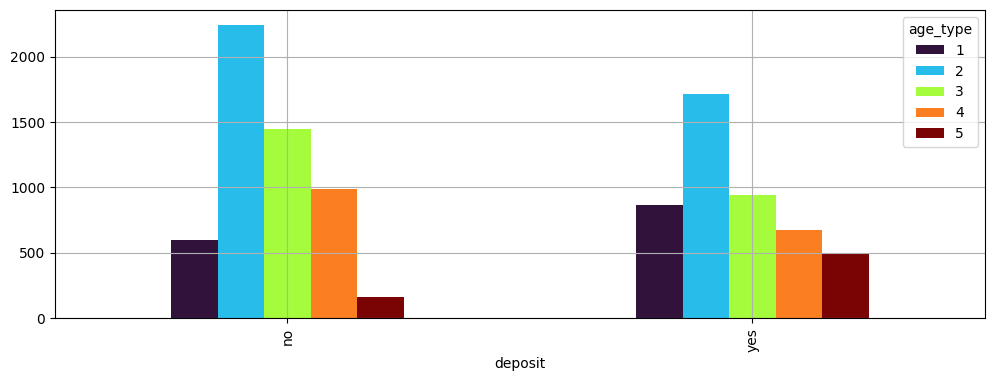

In [28]:
tab1.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

> Давайте посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

- семейное положение;
- уровень образования;
- сфера занятости.

> Постройте визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для всех категорий предложенных выше трёх признаков. Постарайтесь оформить диаграммы максимально наглядно и описать полученный результат.

> К каким категориям относится бόльшая часть людей? Среди каких групп населения есть тенденция соглашаться открывать депозит, а среди каких — отказываться?

### Задания 9 и 10

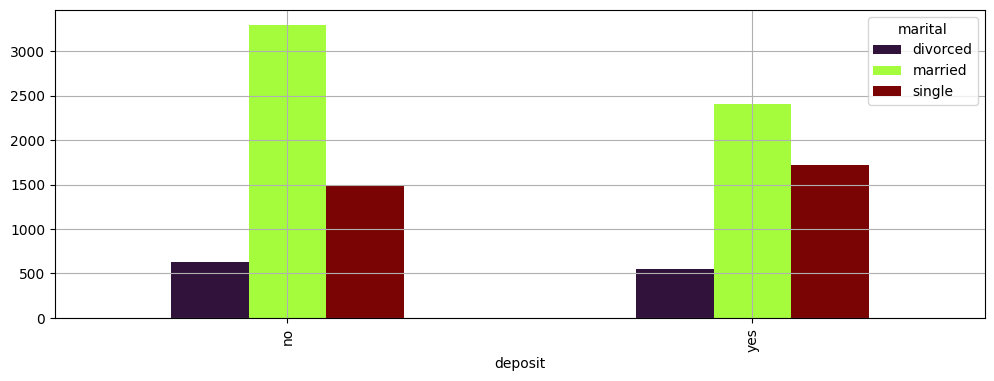

In [29]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

tab2 = df.pivot_table(
    values = 'job',
    index='deposit',
    columns='marital',
    aggfunc='count',
    fill_value=0
    )
tab2.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

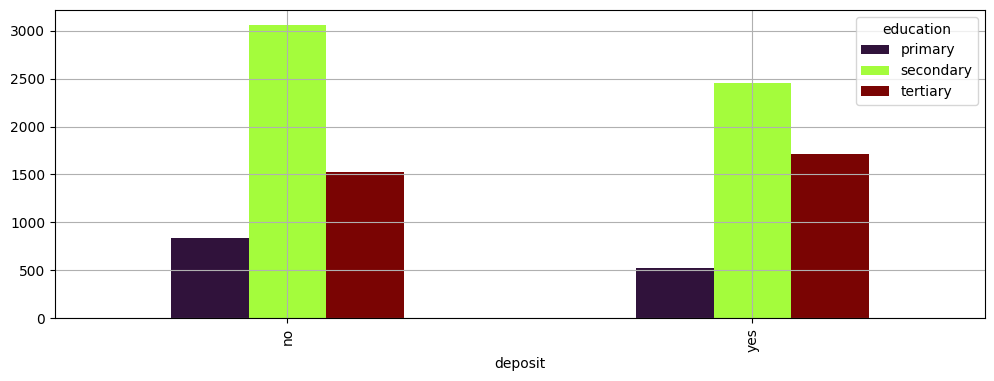

In [30]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

tab3 = df.pivot_table(
    values = 'job',
    index='deposit',
    columns='education',
    aggfunc='count',
    fill_value=0
    )
tab3.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

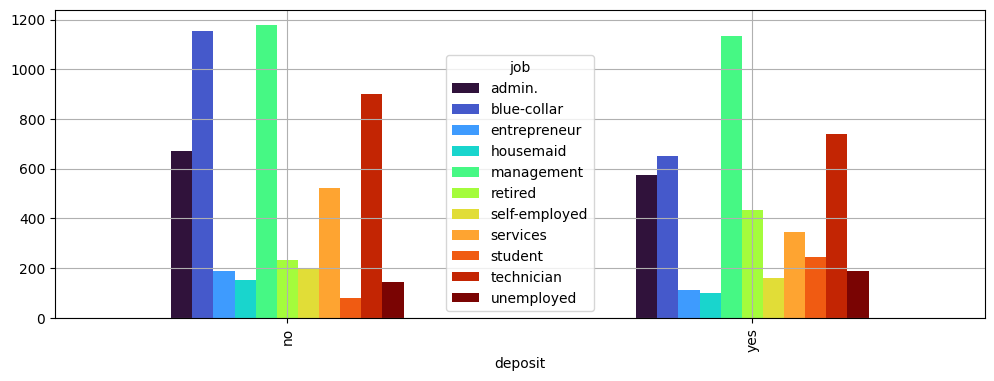

In [31]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

tab4 = df.pivot_table(
    values = 'marital',
    index='deposit',
    columns='job',
    aggfunc='count',
    fill_value=0
    )
tab4.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

> В предыдущих заданиях мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

> Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постройте сводную диаграмму по уровню образования и семейному положению. Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? Какой вывод вы можете сделать, исходя из полученных данных?

### Задание 11

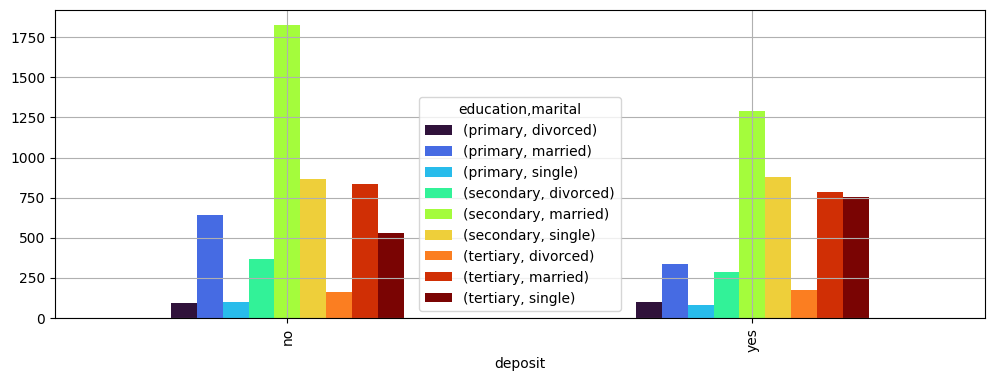

In [32]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

tab5 = df.pivot_table(
    values = 'job',
    index='deposit',
    columns=['education', 'marital'],
    aggfunc='count',
    fill_value=0
    )
tab5.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='turbo'
);

## Часть 3: преобразование данных

### Задание 1

> Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

> Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек. 

In [33]:
# преобразуйте уровни образования
# Найдите сумму получившихся значений для признака education.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].sum()

np.int64(11995)

### Задания 2 и 3

> Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

> Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [34]:
# преобразуйте бинарные переменные в представление из нулей и единиц

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['age_type'] = le.fit_transform(df['age_type'])
df[['age_type', 'age']]

,age_type,age
0,3,59
1,3,56
2,2,41
3,3,55
4,3,54
...,...,...
11157,1,33
11158,1,39
11159,1,32
11160,2,43


> Ранее мы создали порядковую переменную для возраста. Обработайте её по такому же принципу, чтобы её можно было использовать при обучении модели.

> Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, давайте перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [35]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.
df['deposit'] = le.fit_transform(df['deposit'])
df['deposit'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

> Сделаем то же самое для других бинарных переменных, которых у нас три:

- 'default';
- 'housing';
- 'loan'.
> Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [36]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, 
# сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

df['default'] = le.fit_transform(df['default'])
df['housing'] = le.fit_transform(df['housing'])
df['loan'] = le.fit_transform(df['loan'])

In [37]:
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)

np.float64(0.635)

> Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.
> Создайте для них dummy-переменные и добавьте их в набор данных.

### Задание 4

In [38]:
data = df.copy()

In [39]:
cols = ['job', 'marital', 'contact', 'month', 'poutcome']
encoder = ce.OneHotEncoder(cols=cols, use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data[['job', 'marital', 'contact', 'month', 'poutcome']])
data = pd.concat([data, type_bin], axis=1)

In [40]:
data

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_dec,month_jan,month_feb,month_mar,month_apr,month_sep,poutcome_unknown,poutcome_other,poutcome_failure,poutcome_success
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,...,0,0,0,0,1,0,1,0,0,0
11158,39,services,married,1,0,733.0,0,0,unknown,16,...,0,0,0,0,0,0,1,0,0,0
11159,32,technician,single,1,0,29.0,0,0,cellular,19,...,0,0,0,0,0,0,1,0,0,0
11160,43,technician,married,1,0,0.0,0,1,cellular,8,...,0,0,0,0,0,0,0,0,1,0


In [41]:
data.shape[1]

51

In [42]:
data = data.drop(cols, axis=1)

> Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

> Для этого постройте матрицу корреляций. Дополните её тепловой картой, отражающей результат. Не забудьте, что для того, чтобы вычислить коэффициенты корреляции, необходимо, чтобы целевая переменная была числовой.

> В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.

### Задания 5 и 6

<Axes: >

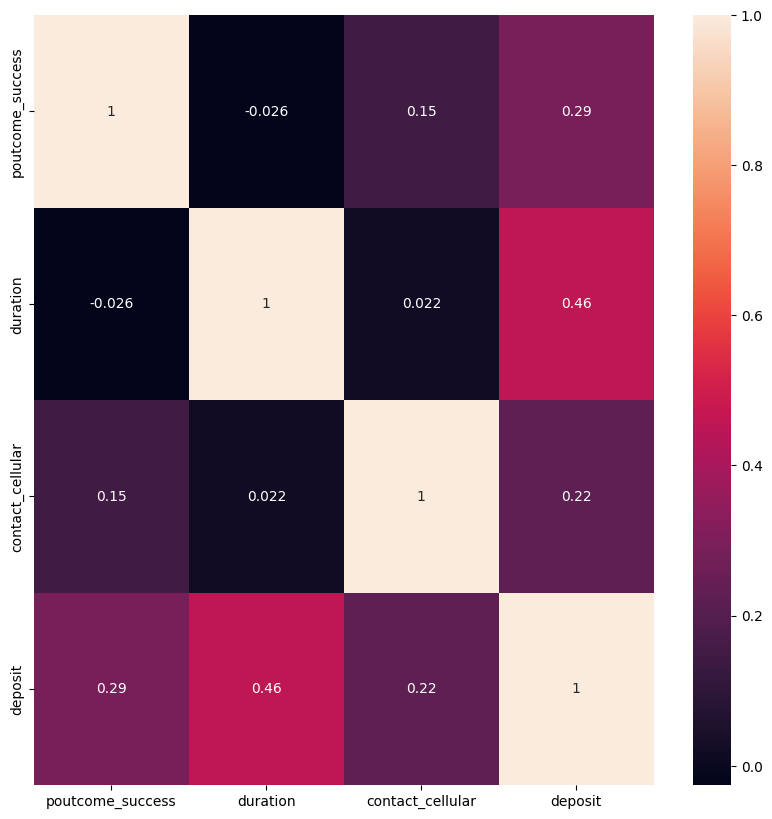

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

data[['poutcome_success', 'duration', 'contact_cellular']]

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))
sns.heatmap(data[['poutcome_success', 'duration', 'contact_cellular', 'deposit']].corr(numeric_only=True), annot=True)

### Задания 7 и 8

> Теперь вам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

> При разбиении задайте параметр random_state = 42, а размер тестовой выборки возьмите за 0.33. Не забудьте добавить аргумент, определяющий сохранение соотношений целевого признака.

In [44]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [45]:
# рассчитайте необходимые показатели
print(X_test.shape)
print(round(y_test.mean(), 2))

(3335, 45)
0.46


> На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

> С помощью SelectKBest отберите 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.

> Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

### Задание 9

In [46]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
list(selector.get_feature_names_out())

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_unknown',
 'contact_cellular',
 'month_may',
 'month_oct',
 'month_mar',
 'month_sep',
 'poutcome_unknown',
 'poutcome_success']

In [47]:
X_train = X_train[list(selector.get_feature_names_out())]
X_test = X_test[list(selector.get_feature_names_out())]

In [48]:
X_train.head()

,balance,housing,loan,duration,campaign,pdays,previous,contact_unknown,contact_cellular,month_may,month_oct,month_mar,month_sep,poutcome_unknown,poutcome_success
7287,557.0,1,0,513,1,-1,0,0,1,0,0,0,0,1,0
4766,69.0,0,1,296,1,205,2,0,1,0,0,0,0,0,0
5712,0.0,1,0,399,2,358,5,0,0,1,0,0,0,0,0
2530,444.0,0,0,137,1,102,5,0,1,0,0,0,0,0,1
9294,1444.0,0,0,100,1,117,8,0,1,0,0,0,0,0,1


> Теперь данные необходимо нормализовать.

> Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.

> Помните, что нормализация требуется для предикторов, а не для целевой переменной.

> Нормализуйте предикторы в обучающей и тестовой выборках.

### Задание 10

In [49]:
col_names = list(X_test.columns)
col_names

['balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'contact_unknown',
 'contact_cellular',
 'month_may',
 'month_oct',
 'month_mar',
 'month_sep',
 'poutcome_unknown',
 'poutcome_success']

In [50]:
# нормализуйте данные с помощью minmaxsxaler

m_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
X_train_scaled = m_scaler.fit_transform(X_train)
X_test_scaled = m_scaler.fit_transform(X_test)

In [51]:
X_test_scaled[:, 0].mean()

# првильный ответ 0.47

np.float64(0.45901814327601437)

In [52]:
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_test_scaled  = pd.DataFrame(X_test, columns=col_names)
X_train_scaled  = pd.DataFrame(X_train, columns=col_names)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

> Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

> Оцените качество модели на тестовой выборке.

### Задание 1

In [53]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [54]:
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1790
           1       0.72      0.77      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.76      0.75      3335
weighted avg       0.76      0.75      0.75      3335



> Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

- criterion = 'entropy';
- random_state = 42.

> Остальные параметры оставьте по умолчанию.

### Задания 2,3,4

In [55]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [56]:
y_test_pred = dt_clf.predict(X_test_scaled)
y_train_pred = dt_clf.predict(X_train_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred ))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



> Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

**Какое наибольшее значение accuracy у вас получилось? Ответ округлите до двух знаков после точки-разделителя.**

In [57]:
# зададим пространство поиска гиперпараметров
space={'max_depth' : hp.quniform('max_depth', 1, 50, 1)
      }

In [58]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'max_depth': int(params['max_depth'])
              }
  
    # используем эту комбинацию для построения модели
    model = tree.DecisionTreeClassifier(**params, random_state=random_state)

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [59]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:02<00:00,  7.82trial/s, best loss: -0.8010339734121121]
Наилучшие значения гиперпараметров {'max_depth': np.float64(8.0)}
CPU times: total: 234 ms
Wall time: 2.56 s


In [60]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    max_depth=int(best['max_depth'])
)
model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train_scaled)
y_test_pred = model_rf.predict(X_test_scaled)
print('accuracy на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy на тренировочном наборе: 0.85
accuracy на тестовом наборе: 0.83


In [61]:
param_distributions = {'max_depth': list(np.linspace(5, 50, 1, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 15, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
y_test_pred = random_search_forest.predict(X_test_scaled)
print('accuracy на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 203 ms
Wall time: 459 ms
accuracy на тренировочном наборе: 0.82
accuracy на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': np.int64(5)}


> Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

> Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

- 'min_samples_split': [2, 5, 7, 10];
- 'max_depth':[3,5,7].

### Задание 5

In [62]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }

grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid = param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
y_train_pred = grid_search.predict(X_train_scaled)
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 266 ms
Wall time: 2.46 s
f1_score на тренировочном наборе: 0.83
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Обучите случайный лес со следующими параметрами:

- n_estimators = 100;
- criterion = 'gini';
- min_samples_leaf = 5;
- max_depth = 10;
- random_state = 42.

### Задание 1

In [64]:
# обучите на ваших данных случайный лес

# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [65]:
y_train_pred = model_rf.predict(X_train_scaled)
y_test_pred = model_rf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770



> Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь предлагаем вам сравнить полученные результаты с моделью градиентного бустинга. Используйте градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

- learning_rate = 0.05;
- n_estimators = 300;
- min_samples_leaf = 5;
- max_depth = 5;
- random_state = 42.

### Задания 2 и 3

In [67]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_scaled)
y_train_pred = gb.predict(X_train_scaled)
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3634
           1       0.86      0.89      0.88      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770



> Вы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

> В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйте модель логистической регрессии.

> Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.

### Задание 4

In [90]:
estimators = [
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, #темп обучения
        n_estimators=300, #число деревьев
        max_depth=5, #максимальная глубина дерева
        random_state=42 #генератор случайных чисел
)),
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
))
]

reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
)

In [91]:
# объедините уже известные вам алгоритмы с помощью стекинга 
reg.fit(X_train_scaled,y_train)

StackingClassifier(estimators=[('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [92]:
y_test_pred = reg.predict(X_test_scaled)
y_train_pred = reg.predict(X_train_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.80      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3634
           1       0.86      0.88      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770



> Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

> Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

### Задание 5

In [107]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=40, step=1)
selector = selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_unknown', 'contact_cellular', 'month_may',
       'month_oct', 'month_mar', 'month_sep', 'poutcome_unknown',
       'poutcome_success'], dtype=object)

In [108]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train_scaled, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_unknown', 'contact_cellular', 'month_may',
       'month_oct', 'month_mar', 'month_sep', 'poutcome_unknown',
       'poutcome_success'], dtype=object)

> Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:

- n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
- max_depth = trial.suggest_int('max_depth', 10, 30, 1);
- min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

### Задания 6,7,8

In [187]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
    model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    model_rf.fit(X_train_scaled, y_train)
    y_test_pred = model_rf.predict(X_test_scaled)
    f1 = metrics.f1_score(y_test, y_test_pred)
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    
    return round(float(f1),2), round(float(accuracy),2)

In [188]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", directions=["maximize", "maximize"])
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-03-21 14:36:39,060] A new study created in memory with name: RandomForestClassifier
[I 2025-03-21 14:36:39,733] Trial 0 finished with values: [0.82, 0.82] and parameters: {'n_estimators': 184, 'max_depth': 16, 'min_samples_leaf': 5}.
[I 2025-03-21 14:36:40,119] Trial 1 finished with values: [0.82, 0.83] and parameters: {'n_estimators': 102, 'max_depth': 20, 'min_samples_leaf': 4}.
[I 2025-03-21 14:36:40,608] Trial 2 finished with values: [0.81, 0.82] and parameters: {'n_estimators': 138, 'max_depth': 28, 'min_samples_leaf': 5}.
[I 2025-03-21 14:36:41,256] Trial 3 finished with values: [0.82, 0.83] and parameters: {'n_estimators': 165, 'max_depth': 14, 'min_samples_leaf': 2}.
[I 2025-03-21 14:36:41,700] Trial 4 finished with values: [0.81, 0.82] and parameters: {'n_estimators': 132, 'max_depth': 30, 'min_samples_leaf': 7}.
[I 2025-03-21 14:36:42,058] Trial 5 finished with values: [0.81, 0.82] and parameters: {'n_estimators': 103, 'max_depth': 20, 'min_samples_leaf': 7}.
[I 2025-

CPU times: total: 10.2 s
Wall time: 10.4 s


In [197]:
print("Число лучших решений на парето-фронте:", len(study.best_trials))
for trial in study.best_trials:
    print("Значения метрик (F1, Accuracy):", trial.values)
    print("Параметры:", trial.params)
    print()

Число лучших решений на парето-фронте: 5
Значения метрик (F1, Accuracy): [0.82, 0.83]
Параметры: {'n_estimators': 102, 'max_depth': 20, 'min_samples_leaf': 4}

Значения метрик (F1, Accuracy): [0.82, 0.83]
Параметры: {'n_estimators': 165, 'max_depth': 14, 'min_samples_leaf': 2}

Значения метрик (F1, Accuracy): [0.82, 0.83]
Параметры: {'n_estimators': 159, 'max_depth': 16, 'min_samples_leaf': 4}

Значения метрик (F1, Accuracy): [0.82, 0.83]
Параметры: {'n_estimators': 138, 'max_depth': 14, 'min_samples_leaf': 5}

Значения метрик (F1, Accuracy): [0.82, 0.83]
Параметры: {'n_estimators': 141, 'max_depth': 16, 'min_samples_leaf': 5}



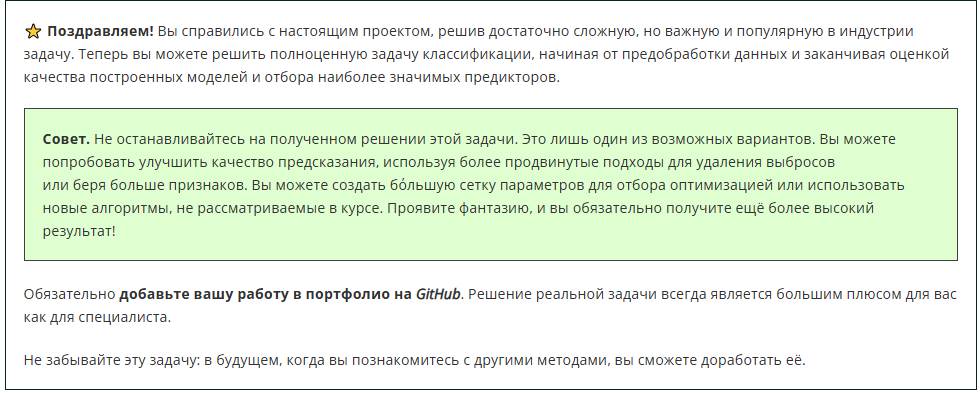